# HW02 Overview

Please complete all core assignment tasks. For 50% bonus points please complete the optional stretech assignment tasks that will involve more theory and programming.


## Please consult Canvas for the full grading rubric (check Module 02 -> HW 02).

The best approach is to work through this notebook. To cross-check your work, you can verify you have completed the sections marked "TASK:"

Broadly speaking you will be graded on the following:

* Download the data and preprocess the data
* Configure and perform a grid search over the specified range of hyperparameter settings
* Visualize the results of gridsearch and discuss the best model
* Report performance on the held-out test set; present a table of results (for the different models you build)
* For the optional tasks, you will need to review and complete the code provided.


__For your reference, following is the grading rubric from Canvas.__
* The homework is based on a total of 40 points (required tasks only).  
* The last two rows are optional, extra-credit assignments.

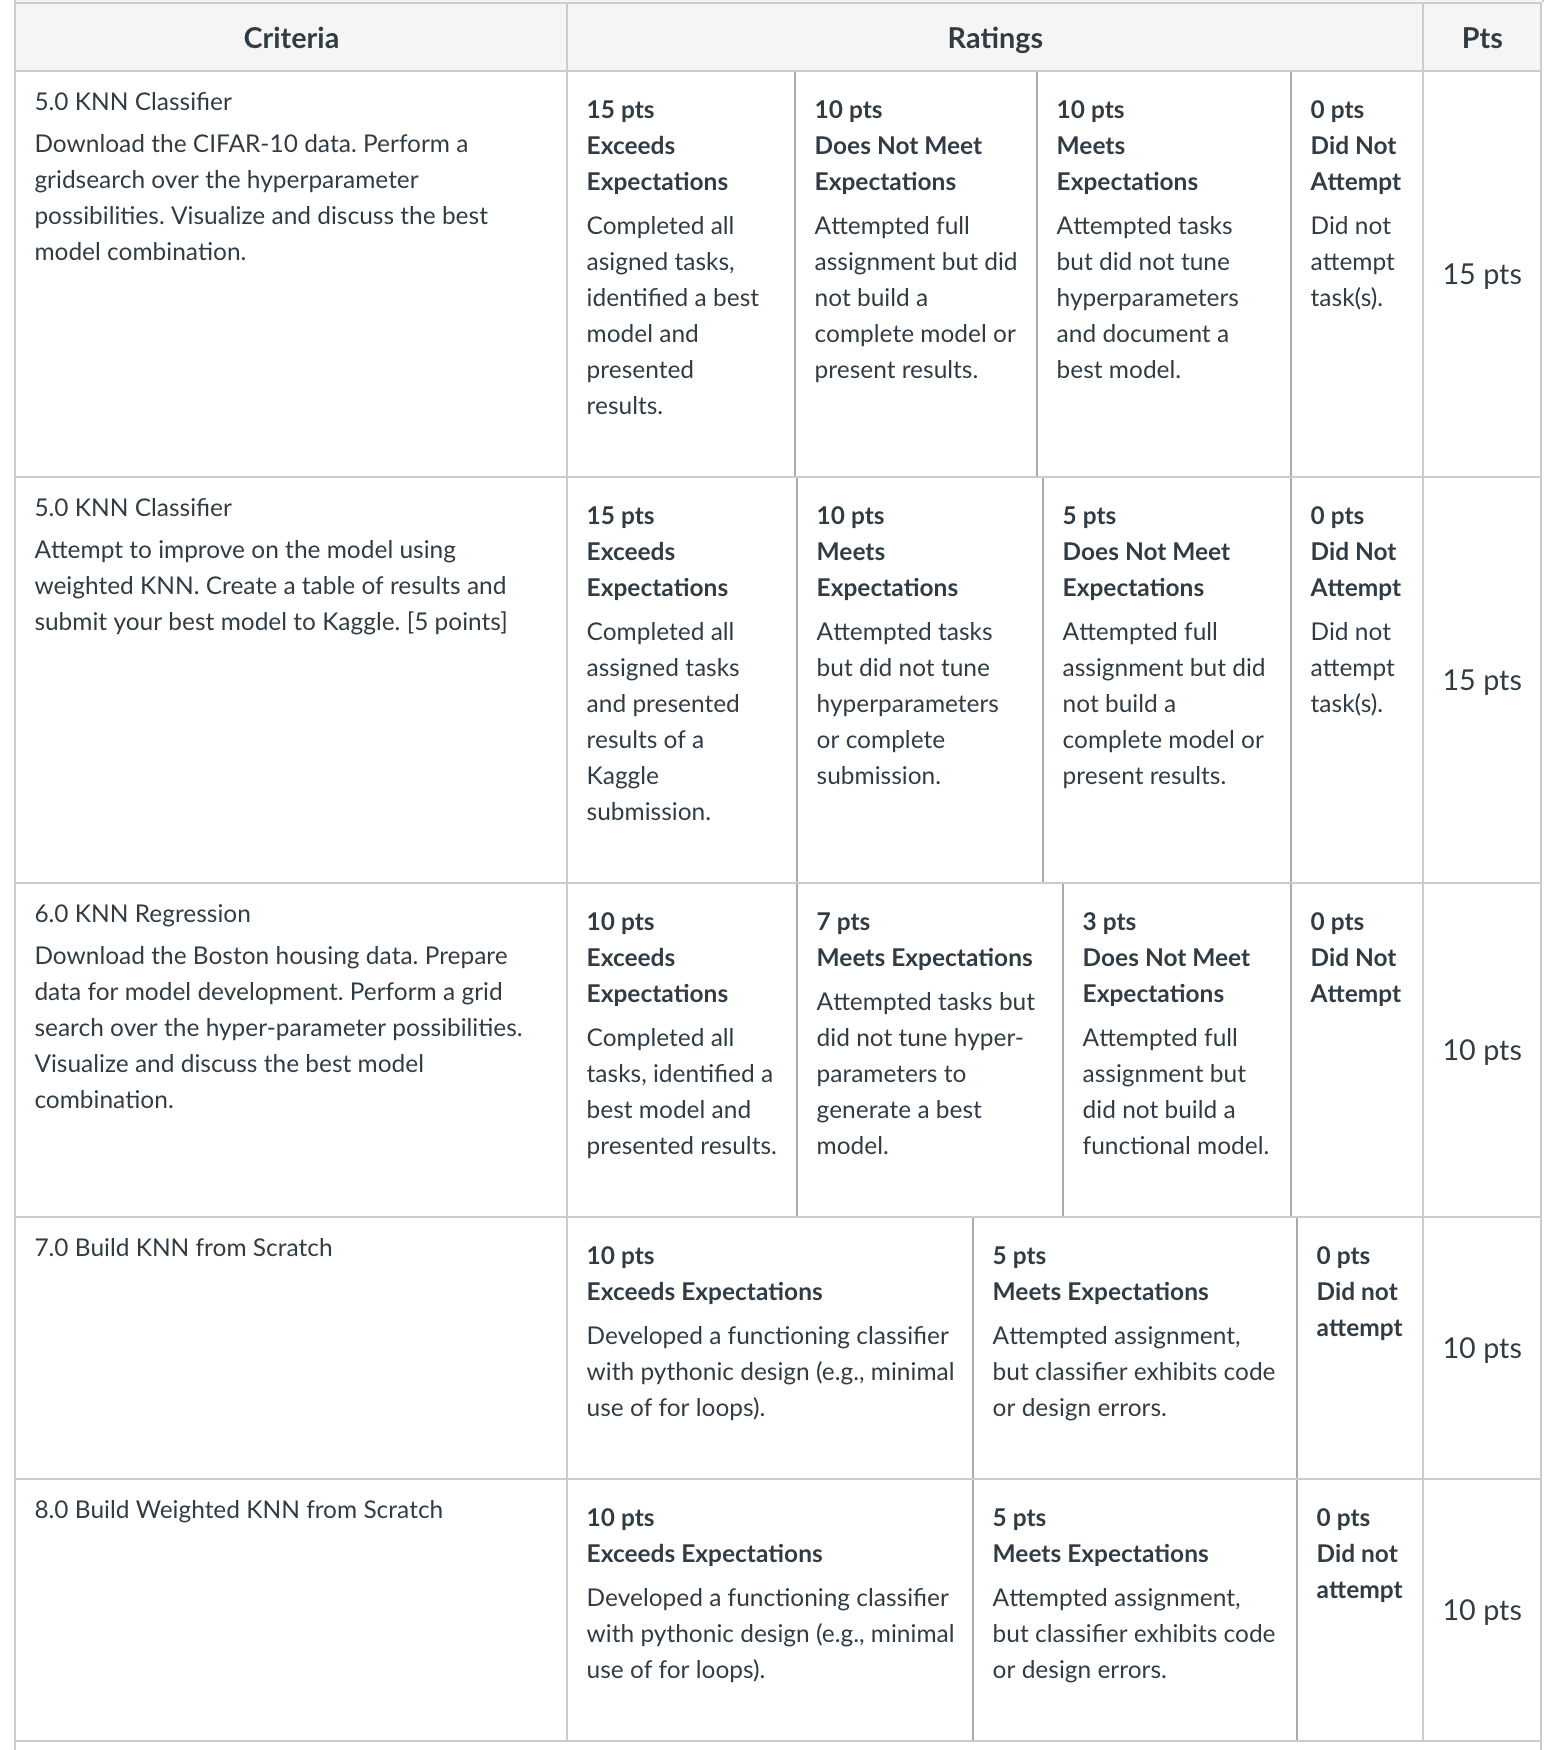

# Image classification dataset: CIFAR10

In this homework, we will be using a couple of datasets. The bigger one is this Image classification dataset: CIFAR10.

** Please DOWNLOAD image DATA FROM [HERE](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) AND PUT IT TO THE DATA FOLDER** 

The [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks. Such a situation is called **multiclass** classification in oppose to **multilabel** classification when each example may have multiple label.

One can see state-of-the-art results [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

In [1]:
import _pickle as cPickle
import tarfile

import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Fix random seed for reproducibility

In [3]:
np.random.seed(42)

# Upacking the Data and doing EDA
In this section we unpack the CIFAR-10 Data set and do some exploratory data analysis

Unarchive data

In [ ]:
tar = tarfile.open("data/cifar-10-python.tar.gz", "r:gz")
tar.extractall("data")
tar.close()

## Reading

Data are stored as a memory dump with python $\text{dict}$ object. It was created using **pickle** function. To read one should "unpickle" it.

In [4]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding='latin1')
    fo.close()
    return dict

Data are also splitted in to 5 pieces for conveniece. Let's read them all and concatenate

In [5]:
for b in range(1, 6):
    data_batch = unpickle("data/cifar-10-batches-py/data_batch_" + str(b))
    if b == 1:
        X_train = data_batch["data"]
        y_train = np.array(data_batch["labels"])
    else:
        X_train = np.append(X_train, data_batch["data"], axis=0)
        y_train = np.append(y_train, data_batch["labels"], axis=0)

Read test data. In this dataset train/test split is provided by authors of the dataset to be able to consistently evaluate solutions

In [6]:
data_batch = unpickle("data/cifar-10-batches-py/test_batch")
X_test = data_batch["data"]
y_test = np.array(data_batch["labels"])

Read meta-information file with the names of the classes

In [7]:
classes = unpickle("data/cifar-10-batches-py/batches.meta")["label_names"]

## Pre-processing

We have too many data

In [8]:
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 50000
Test size: 10000


### Downsample the data so we can experiment more easily
Let's downsample (common strategy to get a POC, proof of concept working) the data by taking a random sample of 10% the training and test sets. This will  allow us to do some experiments much more quickly. **PLEASE do NOT FORGET to use all the data for Kaggle submissions**.

In [9]:
subsample_rate = 0.1

We want to preserve the same quantity ratio between classes. In python such an option is called **stratification**. Let's randomly (with fixed initial seed for the sake of reproducibility) divide part of train data

In [10]:
X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=subsample_rate, random_state=42)

/Users/jamie/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The same for test

In [11]:
X_test, _, y_test, _ = train_test_split(X_test, y_test, stratify=y_test, train_size=subsample_rate, random_state=42)

/Users/jamie/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Build a table for results

In [12]:
results = pd.DataFrame(columns=["Model", "Test Accuracy"])

# Assignment (Section 5 in the Lab Notebook)

In order to complete this lab successfully, please review the following lab:
* `CrossvalidationAndGridSearch-Tutorial.ipynb` from Unit 02 Labs folder.

## K Nearest Neighbors: Grid Search
Using the CIFAR-10 dataset, use the built-in Sklearn implementation of KNN classifier and find out the best set of parameters from the following range:

$$
\text{n_neighbors} \in \{1 \ldots 5\}\\
\text{p} \in \{1 \ldots 3\}
$$

where $\text{n_neighbors}$ is the number of neighbors to consider and $\text{p}$ is the order of $L_p$ metric (see explanation below)


### Sklearn  GridSearch with Cross Validation
Complete the code in this section to do the above hyperparameter tuning via SKLearn's `GridSearchCV` over the training set only. The test dataset should only be used to report your findings after you have committed to your best model(s).

Please use SKlearn KNN.

In [13]:
knn_sk = KNeighborsClassifier(n_jobs=-1)

And specify the dictionary of parameters we want to optimize along with their ranges

In [14]:
### create parameter ranges listed above 
n_neighbors_range = list(range(1,6))
p_range = list (range(1,4))

parameters = {'n_neighbors': n_neighbors_range, 'p': p_range}

$\text{GridSearchCV}$ function does all the stuff. There are three main arguments:
* $\text{estimator} = \text{knn_sk} -$classifier to use; KNN from sklearn defined before
* $\text{param_grid} = \text{parameters} -$parameters ranges to test
* $\text{cv} = \text{split} -$splitting iterator to use

In [17]:
# comfirm we are using a subsample of the data
X_train.shape

(5000, 3072)

In [18]:
%%time
best_model = GridSearchCV(estimator=knn_sk, 
                          param_grid=parameters,  
                          cv=5, 
                          refit=False,  
                          return_train_score=False,
                          verbose=2,
                          n_jobs=-1)
best_model.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] n_neighbors=1, p=1 ..............................................
[CV] n_neighbors=1, p=1 ..............................................
[CV] n_neighbors=1, p=1 ..............................................
[CV] n_neighbors=1, p=1 ..............................................
[CV] n_neighbors=1, p=1 ..............................................
[CV] n_neighbors=1, p=2 ..............................................
[CV] n_neighbors=1, p=2 ..............................................
[CV] n_neighbors=1, p=2 ..............................................
[CV] ............................... n_neighbors=1, p=1, total=  37.8s
[CV] n_neighbors=1, p=2 ..............................................
[CV] ............................... n_neighbors=1, p=1, total=  39.1s
[CV] n_neighbors=1, p=2 ..............................................
[CV] ............................... n_neighbors=1, p=1, total=  39.2s
[CV] ...........

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.9min


[CV] ............................... n_neighbors=3, p=1, total=  28.8s
[CV] n_neighbors=3, p=1 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=  29.1s
[CV] n_neighbors=3, p=1 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=  30.4s
[CV] n_neighbors=3, p=2 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=  30.4s
[CV] n_neighbors=3, p=2 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=  30.5s
[CV] n_neighbors=3, p=2 ..............................................
[CV] ............................... n_neighbors=3, p=2, total=  32.9s
[CV] n_neighbors=3, p=2 ..............................................
[CV] ............................... n_neighbors=3, p=2, total=  33.7s
[CV] n_neighbors=3, p=2 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 27.4min finished


Let's retrieve best parameters

In [19]:
best_p = best_model.best_params_["p"]
best_n = best_model.best_params_["n_neighbors"]
print("best_p: ",best_p)
print("best_n: ",best_n)

best_p:  1
best_n:  5


### best_model.cv_results_ holds a lot of useful information

Please have a closer look at  

* best_model.cv_results_["param_n_neighbors"]                
* best_model.cv_results_["param_p"]
* best_model.cv_results_["mean_test_score"] 


In [20]:
# have a look at CV dictionary of results
best_model.cv_results_

{'mean_fit_time': array([2.1639636 , 2.91988969, 3.23827381, 4.62359786, 4.96233907,
        4.14211764, 4.05429163, 4.83452559, 4.30368586, 5.21363358,
        5.34723673, 5.78349123, 5.19531646, 6.02795534, 6.117942  ]),
 'std_fit_time': array([0.2377489 , 0.82768252, 0.06528594, 0.25702762, 0.41570958,
        1.02151413, 0.8189295 , 0.16316203, 0.4438685 , 0.09259026,
        0.19955296, 0.57187925, 0.5444647 , 0.3551796 , 0.59721616]),
 'mean_score_time': array([ 36.76053281,  34.51366854, 428.21817303,  26.16999679,
         28.58604307, 421.81160245,  25.80839434,  28.31474018,
        435.55510311,  25.79614201,  29.90699863, 478.70636883,
         30.19817319,  34.07061958, 353.4578301 ]),
 'std_score_time': array([ 0.41769786,  4.41924019,  0.82872821,  0.38043814,  0.20063507,
         4.75982977,  0.19341443,  0.46855321,  2.28127102,  0.14746103,
         1.20264017,  4.20678619,  0.61692841,  0.6828834 , 79.35265244]),
 'param_n_neighbors': masked_array(data=[1, 1, 1, 2, 

### Task: report any interesting aspect of best_model
Please report and discuss any interesting aspect of best_model dictionary (there is no wrong or right response here!)

### Visualize the performance metrics along each hyperparameter


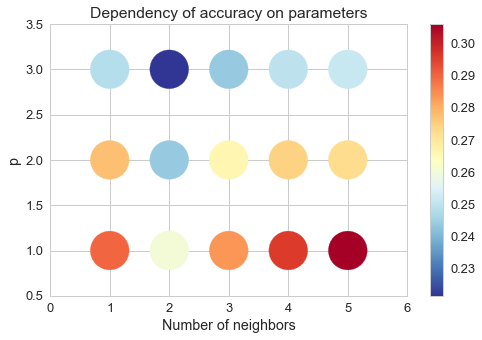

In [25]:
plt.figure(figsize=(8, 5))
sc = plt.scatter(best_model.cv_results_["param_n_neighbors"], 
                 best_model.cv_results_["param_p"], 
                 c=best_model.cv_results_["mean_test_score"], 
                 cmap = plt.get_cmap("RdYlBu_r"), 
                 s=1500)
plt.colorbar(sc)
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.xlabel("Number of neighbors")
plt.ylabel("p")
plt.title("Dependency of accuracy on parameters")
plt.xlim([0, 6])
plt.ylim([0.5, 3.5]);

Let's choose the best $p^*$ and see how accuracy depends on the number of nearest neightbors for a KNN classifier  $p$

In [21]:
p_idx = best_model.cv_results_["param_p"].data == best_p

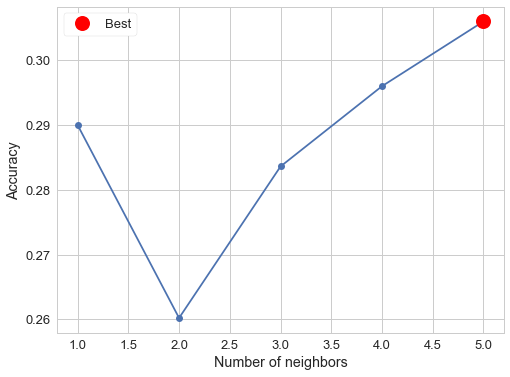

In [23]:
plt.figure(figsize=(8,6))
plt.plot(best_model.cv_results_["param_n_neighbors"].data[p_idx], 
         best_model.cv_results_["mean_test_score"][p_idx], 
         "o-")
plt.plot([best_n], [best_model.cv_results_["mean_test_score"][p_idx][best_n - 1]], "or", markersize=15, label="Best")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.title("")
plt.grid(True)
plt.legend(numpoints=1)
plt.show()

Let's add this result to the table of results.

In [26]:
acc = best_model.best_score_
results.loc[len(results)] = ["KNN Grid Search Sklearn", np.round(acc, 3)]

### Refit estimator with best parameters 
Note: This is required because we ran GridSearchCV with refit='False'.

In [27]:
knn = KNeighborsClassifier(n_neighbors=5, p=1, n_jobs=-1)
knn.fit(X_train, y_train)
y_preds = knn.predict(X_test)

In [28]:
acc = accuracy_score(y_test, y_preds)
results.loc[len(results)] = ["KNN Grid Search Test", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Grid Search Sklearn,0.306
1,KNN Grid Search Test,0.286


### Task
Please do Grid Search with weighted KNN and see if you can improve. Please report the accuracy on the test set.

In [30]:
%%time 

knn_weighted = KNeighborsClassifier(n_jobs=-1, weights='distance')
n_neighbors_range = list(range(1,6))
p_range = list (range(1,4))
parameters = {'n_neighbors': n_neighbors_range, 'p': p_range}

knn_weighted_gs = GridSearchCV(knn_weighted, parameters, cv=5, n_jobs=-1, verbose=2)
knn_weighted_gs.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] n_neighbors=1, p=1 ..............................................
[CV] n_neighbors=1, p=1 ..............................................
[CV] n_neighbors=1, p=1 ..............................................
[CV] n_neighbors=1, p=1 ..............................................
[CV] n_neighbors=1, p=1 ..............................................
[CV] n_neighbors=1, p=2 ..............................................
[CV] n_neighbors=1, p=2 ..............................................
[CV] n_neighbors=1, p=2 ..............................................
[CV] ............................... n_neighbors=1, p=1, total=  36.0s
[CV] n_neighbors=1, p=2 ..............................................
[CV] ............................... n_neighbors=1, p=1, total=  36.4s
[CV] n_neighbors=1, p=2 ..............................................
[CV] ............................... n_neighbors=1, p=1, total=  37.1s
[CV] n_neighbors

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.1min


[CV] ............................... n_neighbors=3, p=1, total=  30.5s
[CV] n_neighbors=3, p=1 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=  31.1s
[CV] n_neighbors=3, p=1 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=  30.7s
[CV] n_neighbors=3, p=2 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=  30.5s
[CV] n_neighbors=3, p=2 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=  31.4s
[CV] n_neighbors=3, p=2 ..............................................
[CV] ............................... n_neighbors=3, p=2, total=  33.3s
[CV] n_neighbors=3, p=2 ..............................................
[CV] ............................... n_neighbors=3, p=2, total=  33.3s
[CV] n_neighbors=3, p=2 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 106.2min finished


CPU times: user 6.9 s, sys: 964 ms, total: 7.87 s
Wall time: 1h 46min 15s


In [31]:
print('Best parameters:', knn_weighted_gs.best_params_)

Best parameters: {'n_neighbors': 5, 'p': 1}


In [32]:
train_preds = knn_weighted_gs.best_estimator_.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)

test_preds = knn_weighted_gs.best_estimator_.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)

In [33]:
results.loc[len(results)] = ["KNN Weighted Test GS", np.round(test_acc, 3)]

In [34]:
results

,Model,Test Accuracy
0,KNN Grid Search Sklearn,0.306
1,KNN Grid Search Test,0.286
2,KNN Weighted Test GS,0.299


## TASK - Do a submission to the Kaggle competition on [CIFAR](https://www.kaggle.com/c/cifar-10). 

Note that the training set in the competition is exactly the same as in this homework.  To discourage certain forms of cheating (such as hand labeling) Kaggle added 290,000 junk images in its test set. These images are ignored in the scoring, but you will need to predict labels for all 300,000 images. 

You can download the Kaggle test dataset from [this site](https://www.kaggle.com/c/cifar-10/data) in the file called test.7z. You must extract the images from this file using a .7z extractor of your choice. Also, do not forget to use all of the Kaggle test data to generate predictions for your Kaggle submissions (we used just 10% of the data for experimentation).

Report your results in this notebook when submitting an assignment solution. Include a screenshot of your relative position on the scoreboard. 

__** Please note that KNN is a poor performer on this task.**__

For example:
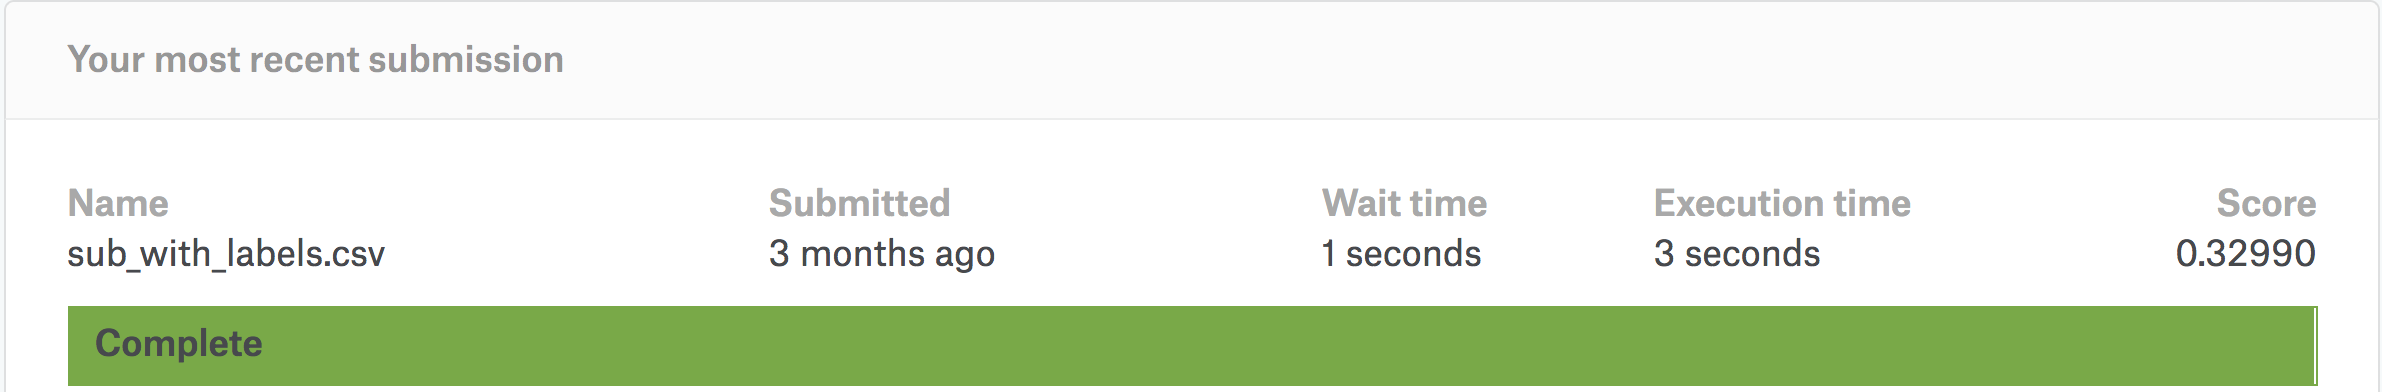

### Load all test data and build a KNN model using best hyperparameter combination

In [35]:
knn = KNeighborsClassifier(n_neighbors=5, p=1, weights='distance', n_jobs=-1)
knn.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=1,
           weights='distance')

### Import test images and generate predictions
The full Kaggle test data can be found <a href="https://www.kaggle.com/c/cifar-10/data">**here**</a> in the file called test.7z (you must extract the images from this file using a .7z extractor of your choice).  For the example code below, these images were extracted to a subdirectory called data/test in the current working directory.

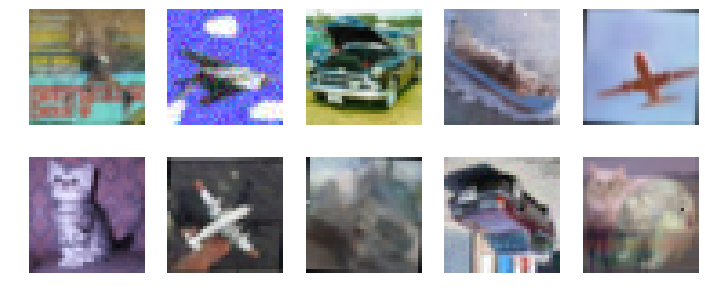

In [40]:
from matplotlib.pyplot import imread

def show_pic(x):
    plt.imshow(x.reshape((3, 32, 32)).transpose(1, 2, 0).astype("uint8"))
    plt.axis("off")
    
    
##  Loading 300,000 images at once requires a lot of resources
##  This code loads and predicts small batches of test data at a time

y_test_preds = []
for batch in range (0, 3):
    X_test = []
    if batch>0:
        first = (batch*100) + 1
        last = (batch*100) + 100
    else:
        first = 1
        last = 101
    for n in range(first,last):
        file = './data/test/'+str((n))+'.png'
        X_test.append(imread(file).transpose(2,0,1)*255)
    X_test = np.array(X_test).reshape(len(X_test),-1)
    y_test_preds.extend(knn.predict(X_test))

    if batch==0:  # sanity check images for first batch only
        plt.figure(figsize=(12, 5))
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            show_pic(X_test[i])

### Output predictions in format required for Kaggle submission

In [43]:
# create a dictionary with each label corresponding to a class number (0 to n-1)
label_dict = {}
for n,c in enumerate(classes):
    label_dict.update({n:c})
label_preds = list(map(label_dict.get, y_preds))

In [44]:
import pandas as pd

# save to csv (with header row and item number in the first column)
ids = list(range(1,300001))
kaggle_submission = pd.DataFrame(columns=['id','label'])
kaggle_submission['id'] = ids
kaggle_submission['label'] = label_preds
kaggle_submission.to_csv('./submission.csv', index=False)

In [48]:
# display top 10 rows of CSV file for Kaggle submission
print(kaggle_submission.shape)
kaggle_submission.head(10)

(300000, 2)


,id,label
0,1,bird
1,2,airplane
2,3,bird
3,4,ship
4,5,bird
5,6,airplane
6,7,bird
7,8,bird
8,9,frog
9,10,airplane


### Sample screenshot of Kaggle submission results
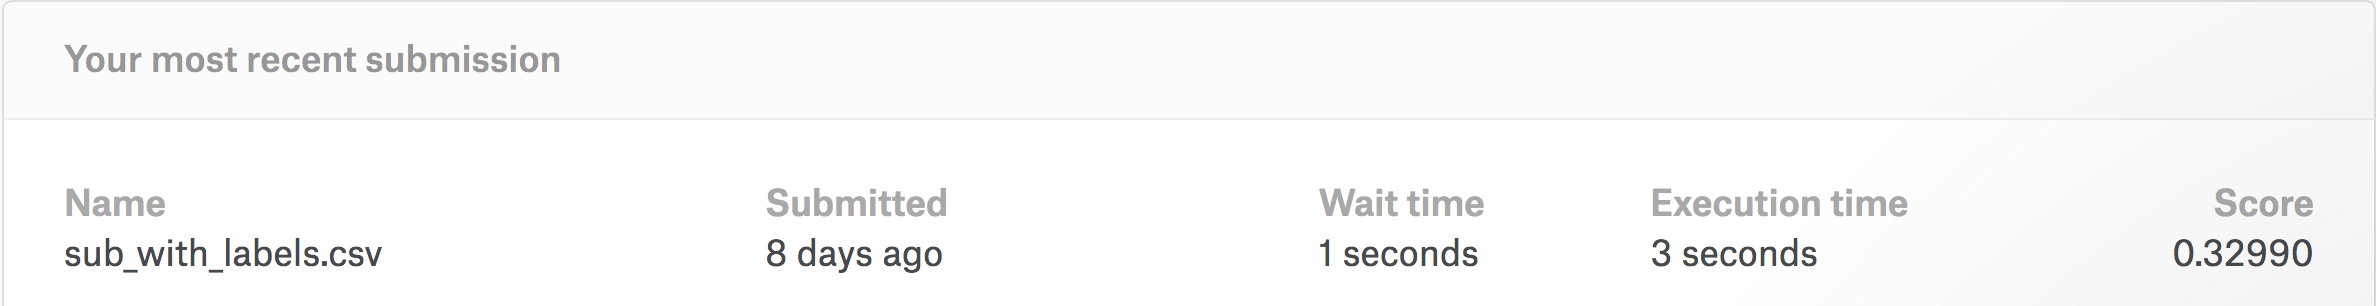

# Assignment: KNN Regression



## Task: KNN regression model for the Boston housing data

Using SKLearn's implemention of KNN, determine a good KNN regression model for the Boston housing data

* put 20% of the data aside as a random test that should not be used during training (and it should be not during hyperparameter tuning). Please use it to report MSE (Mean squared error) on the model you deem best after hyperparameter tuning via GridSearch. 

### Load and split the data

In [46]:
from sklearn.datasets import load_boston
boston = load_boston()
print("Data shape: {}".format(boston.data.shape))

Data shape: (506, 13)


In [47]:
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Conduct grid search to identify and best model

In [50]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

knn_reg = KNeighborsRegressor()
parameters = {'knn__n_neighbors': list(range(1,11)),
              'knn__p': list(range(1,4)),
              'knn__weights': ['uniform', 'distance']}

pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor())])
                
knn_reg_gs = GridSearchCV(pipe, parameters, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

In [51]:
%%time

knn_reg_gs.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] knn__n_neighbors=1, knn__p=1, knn__weights=uniform ..............
[CV] knn__n_neighbors=1, knn__p=1, knn__weights=uniform ..............
[CV] knn__n_neighbors=1, knn__p=1, knn__weights=uniform ..............
[CV] knn__n_neighbors=1, knn__p=1, knn__weights=distance .............
[CV] knn__n_neighbors=1, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=1, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=1, knn__p=2, knn__weights=uniform ..............
[CV]  knn__n_neighbors=1, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=1, knn__p=2, knn__weights=uniform ..............
[CV] knn__n_neighbors=1, knn__p=2, knn__weights=uniform ..............
[CV] knn__n_neighbors=1, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=1, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=1, knn__p=2, knn__weights=distance .............
[CV]  knn__n

[CV] knn__n_neighbors=4, knn__p=2, knn__weights=distance .............
[CV] knn__n_neighbors=6, knn__p=2, knn__weights=uniform ..............
[CV]  knn__n_neighbors=2, knn__p=3, knn__weights=uniform, total=   0.0s
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=2, knn__p=3, knn__weights=uniform ..............
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance .............
[CV]  knn__n_neighbors=2, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=2, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=4, knn__p=2, knn__weights=distance, total=   0.0s
[CV]  knn__n_neighbors=6, knn__p=2, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=4, knn__p=2, knn__weights=distance .............
[CV] knn__n_neighbors=6, knn__p=2, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, total=   0.0s
[CV]  knn__n_neighbors=3, knn__p=3, knn__weights=uniform, total=   

[CV] knn__n_neighbors=7, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=4, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=4, knn__p=1, knn__weights=uniform, total=   0.0s
[CV]  knn__n_neighbors=6, knn__p=3, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=4, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=8, knn__p=2, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=6, knn__p=3, knn__weights=uniform ..............
[CV]  knn__n_neighbors=8, knn__p=1, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=8, knn__p=2, knn__weights=distance .............
[CV] knn__n_neighbors=8, knn__p=2, knn__weights=uniform ..............
[CV]  knn__n_neighbors=2, knn__p=3, knn__weights=distance, total=   0.0s
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.0s
[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=distance, total= 

[CV] knn__n_neighbors=8, knn__p=3, knn__weights=distance .............
[CV]  knn__n_neighbors=9, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=9, knn__p=3, knn__weights=distance .............
[CV]  knn__n_neighbors=8, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=3, knn__weights=distance, total=   0.0s
[CV] knn__n_neighbors=10, knn__p=1, knn__weights=uniform .............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.0s
[CV]  knn__n_neighbors=10, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV] knn__n_neighbors=10, knn__p=1, knn__weights=uniform .............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.0s
[CV]  knn__n_neighbors=10, knn__p=1, knn__weights=uniform, total=   0.0s
[CV] knn__n_neighbors=10, knn__p=1, knn__weights=uniform ........

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.7s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'knn__p': [1, 2, 3], 'knn__weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

### Generate and score predictions using best model

In [52]:
knn_reg_gs.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance'))])

In [53]:
test_preds = knn_reg_gs.best_estimator_.predict(X_test)

In [54]:
from sklearn.metrics import mean_squared_error
results = pd.DataFrame(columns=["Model", "k", "p", "weights","MSE"])
results.loc[len(results)] = ["KNN Regressor Test", knn_reg_gs.best_params_['knn__n_neighbors'],
                             knn_reg_gs.best_params_['knn__p'], knn_reg_gs.best_params_['knn__weights'],
                             round(mean_squared_error(y_test, test_preds),3)]
results

,Model,k,p,weights,MSE
0,KNN Regressor Test,2,2,distance,15.726


# Optional Assignment: K Nearest Neighbors from scratch

Implement K Nearest Neighbors classifier from scratch with the Class provided and do experiments on the CIFAR-10 dataset (from Section 4):

* Take the best parameters from section 4.1 
* Train a classifier
* Report a quality and discuss any differences with the SKLearn implemenentation



K Nearest Neighbors classier is the simplest **metric** classifier. The idea behind it is to find $k$ most *similar* objects and make a classification decision based on them.

To formalize the notion of similarity one should introduce the measure of the difference. Here we're going to use $L_p$ norm and induced metric.

$$
d_p(\mathbf{x}_1, \mathbf{x}_2) = \|\mathbf{x}_1 - \mathbf{x}_2\|_p = \left( \sum_{j=1}^{m}\left| x_{1, \,j} - x_{2, \,j} \right|^p \right)^{1/p}
$$

There are special names for some of the $L_p$ metrics:
* $p=1$ is Manhattan distance
* $p=2$ is Euclidian distance

For other metrics one can see [here](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html)

Process of learning for KNN classifier is no more than just remembering all the training examples to find the closest one later on. There are smart ways (such as [KD trees](https://en.wikipedia.org/wiki/K-d_tree)) of storing training objects to be able to find nearest one very fast (faster than simply scanning through all of them). But here you need to implement it as a simple **array**.

For the prediction the following strategy is used:
* Find $k$ closest examples from train set
* Find the most frequent label among these $k$ closest objects (if there are few labels with the same number of objects than pick any label from those)
* Assign this label to new object

## Re-load and downsample CIFAR-10 dataset

In [77]:
# Load training data
for b in range(1, 6):
    data_batch = unpickle("data/cifar-10-batches-py/data_batch_" + str(b))
    if b == 1:
        X_train = data_batch["data"]
        y_train = np.array(data_batch["labels"])
    else:
        X_train = np.append(X_train, data_batch["data"], axis=0)
        y_train = np.append(y_train, data_batch["labels"], axis=0)

# Load test data
data_batch = unpickle("data/cifar-10-batches-py/test_batch")
X_test = data_batch["data"]
y_test = np.array(data_batch["labels"])

# Load class data
classes = unpickle("data/cifar-10-batches-py/batches.meta")["label_names"]

# Subsample 10%
subsample_rate = 0.1
X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=subsample_rate, random_state=42)
X_test, _, y_test, _ = train_test_split(X_test, y_test, stratify=y_test, train_size=subsample_rate, random_state=42)

/Users/jamie/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [80]:
class KNNHomegrown(object):
    
    def __init__(self, n_neighbors=5, p=2):
        self.n_neighbors = n_neighbors
        self.p = p
        self._train_objects = np.array([])
        self._train_labels = np.array([])
        
    def _metric_func(self, x1, x2):
        """
        Return distance between two objects in Lp metric
        
        Args:
            x1(ndarray): first object
            x2(ndarray): second object
        Return:
            distance(float): Lp distance 
                             between x1 and x2
        """
        
        distance = 0.
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
 
        distance = np.linalg.norm(x1 - x2, ord=self.p, axis=1)
    
        return distance
    
    def _accuracy(self, y_true, y_pred):
        """
        Return the accuracy error measure
        
        Args:
            y_true(ndarray): true labels
            y_pred(ndarray): predicted labels
        Return:
            acc(float):      accuracy
        """
        
        acc = 0.
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
            
        acc = np.mean(y_true == y_pred)
        
        return acc
    
    def fit(self, X, y):
        """
        Fits the KNN classification model
        
        Args:
            X(ndarray): objects to train on
            y(ndarray): labels for each object
        Return:
            self
        """
        
        self._train_objects = np.array([])
        self._train_labels = np.array([])
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
        
        self._train_objects = X
        self._train_labels = y
        
        return self
        
    def _nearest_neighbors(self, X):
        """
        Get n nearest neighbors for each object in X.
        For each object in X returns the array of n
        closest objects in train set.
        
        Args:
            X(ndarray): objects
        Return:
            nearest_indices(ndarray): array of nearest 
                                      objects indices
        """
        
        
        nearest_indices = np.zeros(shape=(X.shape[0], 
                                          self.n_neighbors), dtype=np.int) - 1
        nearest_distances = np.zeros(shape=(X.shape[0], 
                                          self.n_neighbors), dtype=np.int) - 1
        
        #==================================================#
        #               Place your code here               #
        #            Hint: use self._metric_func           #
        #==================================================#

        for i in range(X.shape[0]):
            if (i + 1) % 100 == 0:
                print("Object {} out of {} has been predicted".format(i + 1, X.shape[0]))
            distances = self._metric_func(X[i], self._train_objects)
            index_order = np.argsort(distances)[:self.n_neighbors]
            nearest_indices[i] = index_order
            nearest_distances[i] = distances[index_order]
            
        return (nearest_indices, nearest_distances)
    
    
    def predict(self, X):
        """
        Predict the label for new objects
        
        Args:
            X(ndarray): objects to predict
        Return:
            y(ndarray): labels for objects
        """
        
        y = np.zeros(shape=(X.shape[0],))
        
        #==================================================#
        #               Place your code here               #
        #        Hint: use self._nearest_neighbors         #
        #==================================================#
 
        nearest_indices, nearest_distances = self._nearest_neighbors(X)
        nearest_labels = self._train_labels[nearest_indices]

        for i in range(X.shape[0]):
            y[i] = np.argmax(np.bincount((nearest_labels[i])))
        
        return y
    
    def score(self, X, y):
        """
        Return a dictionary which contains accuracy and Lp
        error metrics
        
        Args:
            X(ndarray):    objects to predict
            y(ndarray):    true labels for objects
        Return:
            metrics(dict): dictionary which contains metrics
        """
        
        y_pred = self.predict(X)
        
        acc = self._accuracy(y, y_pred)
        loss = self._metric_func(y, y_pred)
        
        metrics = {"acc": acc, "loss": loss}
        
        return metrics

In [81]:
model_knn_homegrown = KNNHomegrown(n_neighbors=5, p=1)

In [82]:
model_knn_homegrown.fit(X_train, y_train)

In [83]:
y_pred_test = model_knn_homegrown.predict(X_test)

Object 100 out of 1000 has been predicted
Object 200 out of 1000 has been predicted
Object 300 out of 1000 has been predicted
Object 400 out of 1000 has been predicted
Object 500 out of 1000 has been predicted
Object 600 out of 1000 has been predicted
Object 700 out of 1000 has been predicted
Object 800 out of 1000 has been predicted
Object 900 out of 1000 has been predicted
Object 1000 out of 1000 has been predicted


In [84]:
acc = accuracy_score(y_test, y_pred_test)

In [86]:
results = pd.DataFrame(columns=["Model", "Test Accuracy"])
results.loc[len(results)] = ["KNN Homegrown", np.round(acc, 3)]

In [87]:
results

,Model,Test Accuracy
0,KNN Homegrown,0.224


# Optional Assignment:  K Weighted Nearest Neighbors

## Vanilla KNN using majority voting
For a classification task using KNN, where K > 1, a majority voting can be thought of as the following: let's assign weight $1$ to each of the $K$ neighbors of the test case  and then just sum up the  weights for each class assign the majority class to the label of the test case. In the case of a draw, we can  randomly select a class based upon unform sampling.

## Weight KNN
Rather than assignment a  equal weight of $1$ to each nearest neighbor, let's assume that weight of each object is **inversly proporional** to the distance to test case. It means that the smaller the distance is the more the weight will be $-$ exactly that we want. The classification is done with the same rule $-$ we just sum up weights for each class and choose the class with the largest weight. 

We can follow a similar strategy for KNN Regression.

## Task: implement a weighted  KNN for classification
Implement a weighted  KNN for classification and report your findings on the CIFAR-10 dataset

In [88]:
class KNNWeightedHomegrown(KNNHomegrown):
    
    def __init__(self, n_neighbors=5, p=2, weight_mode="uniform"):
        super(KNNWeightedHomegrown, self).__init__(n_neighbors, p)
        
        if weight_mode != "distance":
            weight_mode = "uniform"
        self.weight_mode = weight_mode
        
        if self.weight_mode == "distance":
            self._weight_func = self._inverse_weights
        else:
            self._weight_func = self._uniform_weights
        
    def _inverse_weights(self, distances):
        """
        Generate neighbors weights which are 
        inversly proportional to the distances from
        object to its neighbor.

        Args:
            distances(ndarray): 2D numpy array
                first axes is objects
                second axes is neighbors of object
                in the cell (i; j) there is distance from
                the i^th object to its j^th nearest neighbor
        Return:
            weights(ndarray):   array of weights
        """ 
        
        weights = np.zeros(shape=distances.shape)
        
        #==================================================#
        #               Place your code here               #
        #            Hint: use self._metric_func           #
        #==================================================#

        weights = 1. / distances
        
        return weights
    
    def _uniform_weights(self, distances):
        """
        Generate neighbors weights which are 
        uniformly distributed.

        Args:
            distances(ndarray): 2D numpy array
                first axes is objects
                second axes is neighbors of object
                in the cell (i; j) there is distance from
                the i^th object to its j^th nearest neighbor
        Return:
            weights(ndarray):   array of weights
        """ 
        
        weights = np.ones(shape=distances.shape)
        
        return weights
        
    def predict(self, X):
        """
        Predict the label for new objects.
        Accounts for neighbors with weights in the
        mode defined in the constructor.
        
        Args:
            X(ndarray): objects to predict
        Return:
            y(ndarray): labels for objects
        """
        
        y = np.zeros(X.shape[0]) - 1
        
        #==================================================#
        #               Place your code here               #
        #        Hint1: use self._nearest_neighbors        #
        #           Hint2: use self._weight_func           #
        #==================================================#

        nearest_indices, nearest_distances = self._nearest_neighbors(X)
        nearest_labels = self._train_labels[nearest_indices]
        
        weights = self._weight_func(nearest_distances)
        
        for i in range(X.shape[0]):     
            counts = np.bincount(nearest_labels[i])
            weighted_sum = counts[nearest_labels[i]] * weights[i]
            y[i] = nearest_labels[i][np.argmax(weighted_sum)]
        
        return y

In [89]:
model_knn_weighted_homegrown = KNNWeightedHomegrown(n_neighbors=5, p=1, weight_mode='distance')

In [90]:
model_knn_weighted_homegrown.fit(X_train, y_train)

In [91]:
y_pred_test = model_knn_weighted_homegrown.predict(X_test)

Object 100 out of 1000 has been predicted
Object 200 out of 1000 has been predicted
Object 300 out of 1000 has been predicted
Object 400 out of 1000 has been predicted
Object 500 out of 1000 has been predicted
Object 600 out of 1000 has been predicted
Object 700 out of 1000 has been predicted
Object 800 out of 1000 has been predicted
Object 900 out of 1000 has been predicted
Object 1000 out of 1000 has been predicted


In [92]:
acc = accuracy_score(y_test, y_pred_test)

In [93]:
results.loc[len(results)] = ["KNN Weighted Homegrown", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Homegrown,0.224
1,KNN Weighted Homegrown,0.227
